In [76]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.ensemble import RandomForestClassifier


In [77]:

# Load the Fair PCA-transformed data
X_train = pd.read_csv('data/X_train.csv', index_col=0)
X_test = pd.read_csv('data/X_test.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0).iloc[:, 0]
y_test = pd.read_csv('data/y_test.csv', index_col=0).iloc[:, 0]


In [78]:

# Train a random forest model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)

shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values[:,:,1], max_display =16)


In [67]:
fair_PCA_train = pd.read_csv('data/X_train_fair_PCA.csv', index_col=0)
fair_PCA_test = pd.read_csv('data/X_test_fair_PCA.csv', index_col=0)


### Finding data points which are ambigious in the model

In [68]:

# Ensure gender filtering uses the original non-scaled data
indexes_with_gender_1 = X_test[X_test['gender'] == 1].index

# Filter the non scaled test data using the indices
X_test_filtered = X_test.loc[indexes_with_gender_1]

# Predict probabilities for the filtered data
probabilities = model.predict_proba(X_test_filtered)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff = np.abs(probabilities[:, 0] - probabilities[:, 1])

# Create a DataFrame to hold the filtered data and the probabilities
filtered_data_with_probs = pd.DataFrame(
    np.column_stack((X_test_filtered.values, probabilities, prob_diff)),
    columns=X_test_filtered.columns.tolist() + ['prob_class_0', 'prob_class_1', 'prob_diff'],
    index=X_test_filtered.index  # Preserve original indices
)


# Load the gold labels for the test set
gold_labels = pd.read_csv('data/y_test.csv', index_col=0)

# Merge the gold labels with the filtered  DataFrame
filtered_with_probs = filtered_data_with_probs.join(gold_labels)


# Sort the data by the absolute difference between the class probabilities
sorted_filtered_data = filtered_with_probs.sort_values(by='prob_diff')

# Output the top 10 data points where the probabilities are most balanced
top_10_balanced = sorted_filtered_data.head(10)

# Display the probabilities for the top 10 balanced data points
for index, row in top_10_balanced.iterrows():
    print(f"Index: {index}, Gold Label: {row['pass_bar']}, "
          f"Probabilities: Class 0 = {row['prob_class_0']:.4f}, "
          f"Class 1 = {row['prob_class_1']:.4f}, "
          f"Difference = {row['prob_diff']:.4f}")




# Load fair PCA data for further analysis
fair_PCA_test = pd.read_csv('data/X_test_fair_PCA.csv', index_col=0)

# Optionally check if indices in `top_10_balanced` are present in `fair_PCA_test`
missing_indices = [idx for idx in top_10_balanced.index if idx not in fair_PCA_test.index]
if missing_indices:
    print("Missing indices in fair_PCA_test:", missing_indices)
else:
    print("All indices are present in fair_PCA_test.")


Index: 19184, Gold Label: 0.0, Probabilities: Class 0 = 0.5000, Class 1 = 0.5000, Difference = 0.0000
Index: 21666, Gold Label: 1.0, Probabilities: Class 0 = 0.5100, Class 1 = 0.4900, Difference = 0.0200
Index: 11417, Gold Label: 1.0, Probabilities: Class 0 = 0.4800, Class 1 = 0.5200, Difference = 0.0400
Index: 12117, Gold Label: 1.0, Probabilities: Class 0 = 0.4800, Class 1 = 0.5200, Difference = 0.0400
Index: 21476, Gold Label: 1.0, Probabilities: Class 0 = 0.5200, Class 1 = 0.4800, Difference = 0.0400
Index: 19990, Gold Label: 1.0, Probabilities: Class 0 = 0.4800, Class 1 = 0.5200, Difference = 0.0400
Index: 21930, Gold Label: 1.0, Probabilities: Class 0 = 0.4800, Class 1 = 0.5200, Difference = 0.0400
Index: 6204, Gold Label: 1.0, Probabilities: Class 0 = 0.4700, Class 1 = 0.5300, Difference = 0.0600
Index: 12277, Gold Label: 1.0, Probabilities: Class 0 = 0.4700, Class 1 = 0.5300, Difference = 0.0600
Index: 16170, Gold Label: 0.0, Probabilities: Class 0 = 0.4700, Class 1 = 0.5300, D

### Evaluating the previsouly ambigious datapoints using the FairPCA transformed data

In [70]:
# Get the indices of the top 10 balanced data points
indices_of_interest = top_10_balanced.index

# Filter the Fair PCA test data
fair_PCA_filtered = fair_PCA_test.loc[indices_of_interest]


In [71]:



# Train a logistic regression model
model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
model.fit(fair_PCA_train, y_train)

# Evaluate on the test set
y_pred = model.predict(fair_PCA_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.641008478357876


In [75]:


# Predict probabilities on the filtered Fair PCA test data
probabilities_fair_pca = model.predict_proba(fair_PCA_filtered)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff_fair_pca = np.abs(probabilities_fair_pca[:, 0] - probabilities_fair_pca[:, 1])

# Create a DataFrame to hold the filtered data and the probabilities
filtered_fair_pca_with_probs = pd.DataFrame(
    np.column_stack((fair_PCA_filtered, probabilities_fair_pca, prob_diff_fair_pca)),
    columns=fair_PCA_filtered.columns.tolist() + ['prob_class_0', 'prob_class_1', 'prob_diff'],
    index=indices_of_interest  # Use the original indices for easy reference
)

# Load the gold labels for the test set
gold_labels = pd.read_csv('data/y_test.csv', index_col=0)

# Merge the gold labels with the filtered Fair PCA DataFrame
filtered_fair_pca_with_probs = filtered_fair_pca_with_probs.join(gold_labels)

# Sort the data by the absolute difference between the class probabilities
sorted_fair_pca = filtered_fair_pca_with_probs.sort_values(by='prob_diff')

# Extract the top 10 data points where the probabilities are most balanced
top_10_balanced_fair_pca = sorted_fair_pca.head(10)

# Display the probabilities and gold labels for the top 10 balanced data points
for index, row in top_10_balanced_fair_pca.iterrows():
    print(f"Index: {index}, Gold Label: {row['pass_bar']}, "
          f"Probabilities: Class 0 = {row['prob_class_0']:.4f}, "
          f"Class 1 = {row['prob_class_1']:.4f}, "
          f"Difference = {row['prob_diff']:.4f}")


Index: 20203, Gold Label: 1.0, Probabilities: Class 0 = 0.5014, Class 1 = 0.4986, Difference = 0.0028
Index: 18849, Gold Label: 1.0, Probabilities: Class 0 = 0.4900, Class 1 = 0.5100, Difference = 0.0200
Index: 6768, Gold Label: 1.0, Probabilities: Class 0 = 0.4822, Class 1 = 0.5178, Difference = 0.0356
Index: 15750, Gold Label: 1.0, Probabilities: Class 0 = 0.4759, Class 1 = 0.5241, Difference = 0.0481
Index: 22308, Gold Label: 0.0, Probabilities: Class 0 = 0.4632, Class 1 = 0.5368, Difference = 0.0735
Index: 22402, Gold Label: 0.0, Probabilities: Class 0 = 0.4602, Class 1 = 0.5398, Difference = 0.0795
Index: 20208, Gold Label: 1.0, Probabilities: Class 0 = 0.5410, Class 1 = 0.4590, Difference = 0.0820
Index: 22029, Gold Label: 0.0, Probabilities: Class 0 = 0.4437, Class 1 = 0.5563, Difference = 0.1125
Index: 8296, Gold Label: 1.0, Probabilities: Class 0 = 0.5580, Class 1 = 0.4420, Difference = 0.1159
Index: 8366, Gold Label: 1.0, Probabilities: Class 0 = 0.4390, Class 1 = 0.5610, Dif

### plot to show how much sure the model became in the top 10 most balanced predictions

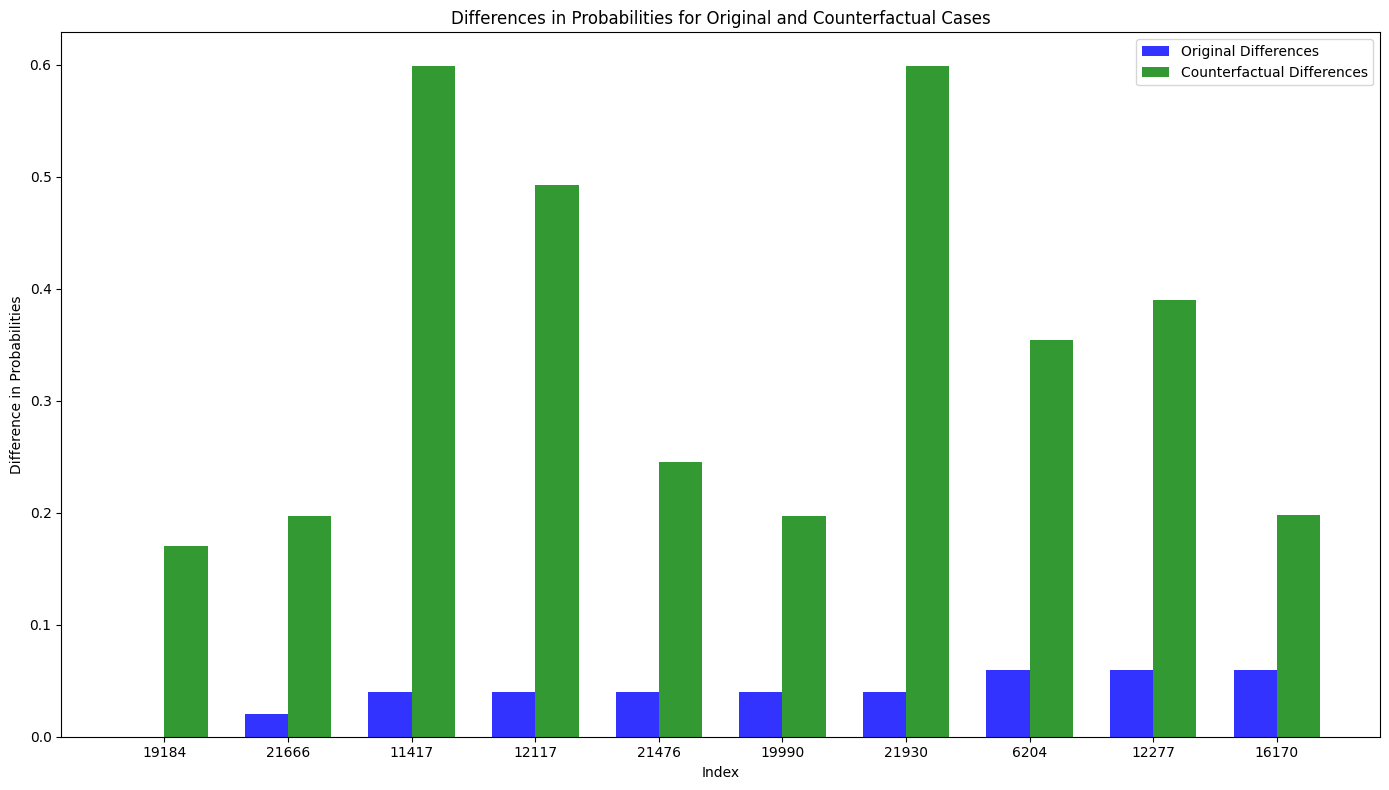

In [73]:
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(x, original_diffs, bar_width,
alpha=opacity,
color='b',
label='Original Differences')

rects2 = plt.bar(x + bar_width, counterfactual_diffs, bar_width,
alpha=opacity,
color='g',
label='Counterfactual Differences')

plt.xlabel('Index')
plt.ylabel('Difference in Probabilities')
plt.title('Differences in Probabilities for Original and Counterfactual Cases')
plt.xticks(x + bar_width / 2, original_indices)
plt.legend()

plt.tight_layout()
plt.show()


In [74]:
def compare_predictions(top_10_balanced, top_10_balanced_fair_pca):

    # Identify observations predicted as class 0 in the original and class 1 in the fair PCA based on probabilities
    changed_predictions = top_10_balanced[
        (top_10_balanced['prob_class_0'] >= top_10_balanced['prob_class_1']) & 
        (top_10_balanced_fair_pca['prob_class_0'] < top_10_balanced_fair_pca['prob_class_1'])
    ]
    
    return changed_predictions

compare_predictions(top_10_balanced, top_10_balanced_fair_pca)

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_27424/3484850795.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  changed_predictions = top_10_balanced[


,decile1b,decile3,decile1,lsat,ugpa,DOB_yr,fam_inc,tier,grad,fulltime,race1_asian,race1_black,race1_hisp,race1_other,race1_white,gender,prob_class_0,prob_class_1,prob_diff,pass_bar
19184,4.0,1.0,4.0,21.5,3.0,64.0,2.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.50,0.50,0.00,0
21552,1.0,1.0,1.0,25.0,2.5,44.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.55,0.45,0.10,0
8494,1.0,1.0,1.0,23.0,2.4,57.0,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.55,0.45,0.10,0
6768,2.0,1.0,2.0,21.0,3.2,68.0,3.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.55,0.45,0.10,1
11098,1.0,1.0,1.0,26.0,2.9,65.0,2.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.56,0.44,0.12,0
8366,1.0,1.0,1.0,24.0,2.4,68.0,3.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.58,0.42,0.16,1


In [ ]:
top_10_balanced.columns

Index(['decile1b', 'decile3', 'decile1', 'lsat', 'ugpa', 'DOB_yr', 'fam_inc',
       'tier', 'grad', 'fulltime', 'race1_asian', 'race1_black', 'race1_hisp',
       'race1_other', 'race1_white', 'gender', 'prob_class_0', 'prob_class_1',
       'prob_diff', 'pass_bar'],
      dtype='object')